# -----------------------------------------------------
# Raiders of the Lost Plateau 
## WALLS - 66 nodes
### Created:   May 2018
### Modified: November 2018
# -----------------------------------------------------

## Notes

1. Not trying to obtain a smooth matrix $C(t)$ converting to zero the eigenvalues below a cutoff value. The matrix $\Lambda(t)$ calculated after it is worst than the obtained with the original $C(t)$.

2. There is no difference in $C^{-1}(t)$ when *rcond* is changed.

3. $\tilde{\Lambda}(t) = -\tilde{\dot{C}}·\tilde{C^{-1}}(t)$ and $\tilde{\Lambda}(t) = E^{-1}·\Lambda(t)·E$ are equivalent if the basis of eigenvectors of $C(t)$, $E$, is time-independent. In this notebook we use the second expression. We prove that the basis used is time-independent.

4. Compute the integral of the correlations using the trapezoidal rule instead of the operator: 

  \begin{array}{cccc}
   1 & 0 & 0 & 0\\
   1 & 1 & 0 & 0\\
   1 & 1 & 1 & 0\\
   1 & 1 & 1 & 1\\
  \end{array}

    With the trapezoidal rule we obtain "better results" of the transport coefficientes to probe the theorem: 

    $\dot{C}(t) = -k_B T M(t) = -k_B ·T·[F^T·\eta(t)·F - G(t)·F - F^T·H(t) + \gamma(t)]$
    
5. Because of the method used in order to build the matrices of correlations (we only compute two blocks of correlations) the components of the bulk will sense the effect of the walls after a certain time. This time can be calculated as a time of diffusion $t$~$L^2/\nu$ or plotting together the correlation in the middle of the canal compute directly with LAMMPS and the same component of the correlation obtained from the blocks. Plotting the correlation in the middle of the canal ($\mu=\nu=33$) calculated from blocks and directly with LAMMPS we obtain that after $t=3$ the curves begin to separate. For $\mu=33$ and $\nu=38$ this time is $t=1$.

# 0. INTRO

## 0.1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import linalg
from scipy.linalg import expm
from numpy import linalg as LA
from numpy.linalg import inv
import scipy.integrate as integrate
from IPython.display import Image

## 0.2. Plot style

In [2]:
# Plot style
sns.set_style("ticks")
# Create palette
thesisPalette = ["royalblue", "darkorange", "darkmagenta", "seagreen", "deeppink", "dimgrey", "darkkhaki", "darkblue", "gold","mediumpurple", "teal"]
sns.set_palette(thesisPalette)
#Font and line width
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.0})
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
size1Fig = 6.4,5
size2Fig = 14,5
size6Fig = 14,15

## 0.3. Load files

In [3]:
Ct = np.loadtxt('Ct-WALLS-66nodes-500steps.dat')
#Ct = np.loadtxt('Ct-WALLS-66nodes.dat')

## 0.4. Parameters

In [4]:
Lx, Ly, Lz  = 40.0, 40.0, 33.0
nNodes      = 66
dz          = Lz / nNodes
nNodesFluid = 61                      
nSteps      = np.shape(Ct)[0]
nCols       = np.shape(Ct)[1]
dt          = 0.004
tol         = 1e-3
nBlocks     = 1                                                            
nVar        = int(np.sqrt(nBlocks))                      
dim         = nVar * nNodes 
Temp        = 2.0
B           = (1 / dz) * ((np.eye(nNodes)) - np.eye(nNodes, nNodes, -1))
F           = B.T
FInv        = inv(F)
Laplacian   = (1 / dz**2) * (-2 * (np.eye(nNodes)) +\
             np.eye(nNodes, nNodes, -nNodes+1) + np.eye(nNodes, nNodes, nNodes-1) +\
             np.eye(nNodes, nNodes, -1) + np.eye(nNodes, nNodes, 1))
tau         = 0.2

## 0.5. Subroutines

In [5]:
#Reshape from vector to matrix
def reshape_vm(A):
    B = A.reshape(nBlocks,nNodes*nNodes).reshape(nVar,nVar,nNodes,nNodes).transpose(0,2,1,3).reshape(dim,dim)
    return B

#Reshape from matrix to vector
def reshape_mv(A):
    B = A.reshape(nVar,nNodes,nVar,nNodes).swapaxes(1,2).ravel()
    return B

#Select the step to which a certain time corresponds
def step(t):
    step = int(round(t/dt))
    return step   

#Select the column to which the autocorrelation of a selected node corresponds
def col(nodeSelected):
    column = (nodeSelected - 1) * nNodes + nodeSelected - 1
    return column

#Replace all values in a matrix < cutOff with zero
def cutOff(A, cutOffValue):
    rows, cols =  np.shape(A)
    B = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            if abs(A[i,j]) > cutOffValue:
                B[i,j] = A[i,j]
            #if A[i,j] > cutOffValue:
            #    B[i,j] = A[i,j]
    return B

#Replace all values in a matrix equal to zero with NaN 
def zeroToNan(A):
    rows, cols =  np.shape(A)
    for i in range(rows):
        for j in range(cols):
            if A[i,j] == 0:
                A[i,j] = np.nan
    return A

#Derivative and integral operators. The derivative is in compliance with the Barrow rule.
ODev      = np.identity(nSteps) - np.eye(nSteps, nSteps, -1) 
OInt      = np.tril(np.ones((nSteps, nSteps), dtype=float), 0) 
ODev[0,0] = 0
ODev /= dt
OInt *= dt

## 0.6. Convert $C(t)$ into an array of 3 dimensions

In [6]:
Ct3D = np.zeros((nNodes, nNodes, nSteps))
for k in range(nSteps):
    Ct3D[:,:,k] = reshape_vm(Ct[k,:])   
Ct = Ct3D

C0 = Ct[:,:,0]
R  = linalg.pinv(C0, rcond = tol)

#### Save files

# 1. REAL SPACE

## 1.1. Compute $\dot{C}_{\mu\nu}(t)$, $C^{-1}_{\mu\nu}(t)$ and $\Lambda_{\mu\nu}(t)$

In [7]:
CtDev    = np.zeros((nNodes, nNodes, nSteps))
CtInv    = np.zeros((nNodes, nNodes, nSteps))
Lambdat  = np.zeros((nNodes, nNodes, nSteps))

for i in range(nNodes):
    CtDev[i,:,:] = ODev.dot(Ct[i,:,:].T).T
    
for k in range(nSteps):
    CtInv[:,:,k]    = linalg.pinv(Ct[:,:,k], rcond = tol)
    Lambdat[:,:,k]  = - CtDev[:,:,k].dot(CtInv[:,:,k])

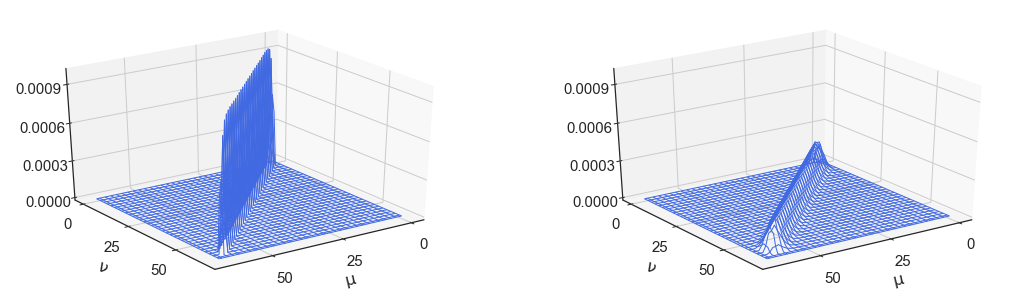

In [8]:
# Select the correct size of the plot
fig = plt.figure()
fig.set_size_inches(18,11)

x = range(nNodes)
y = range(nNodes)

p = 1
for t in np.arange(0, 0.7, 0.6):

    h = fig.add_subplot(2,2,p, projection='3d')
    X, Y = np.meshgrid(x, y) 
    h.plot_wireframe(X, Y, Ct[:,:,step(t)])
    h.set_zlim(0,1e-3)
    h.set_xticks(range(0, 59, 25))
    h.set_yticks(range(0, 59, 25))
    h.set_zticks(np.arange(0, 1e-3, 0.0003))
    #h.set_title(r'$\rm{C_{\mu\nu}('+str(t)+')}$')
    h.set_xlabel(r'$\rm{\mu}$', labelpad=15)
    h.set_ylabel(r'$\rm{\nu}$', labelpad=15)
    #h.ticklabel_format(style='sci', axis='z', scilimits=(0,0))
    h.view_init(30, 55)
    p += 1       
#plt.savefig('../../../figures/Ct-matrix-WALLS-66nodes.pdf'#This is simple recomendation for publication plots
            #,dpi=1000, 
            # Plot will be occupy a maximum of available space
            #bbox_inches='tight') 
plt.show()

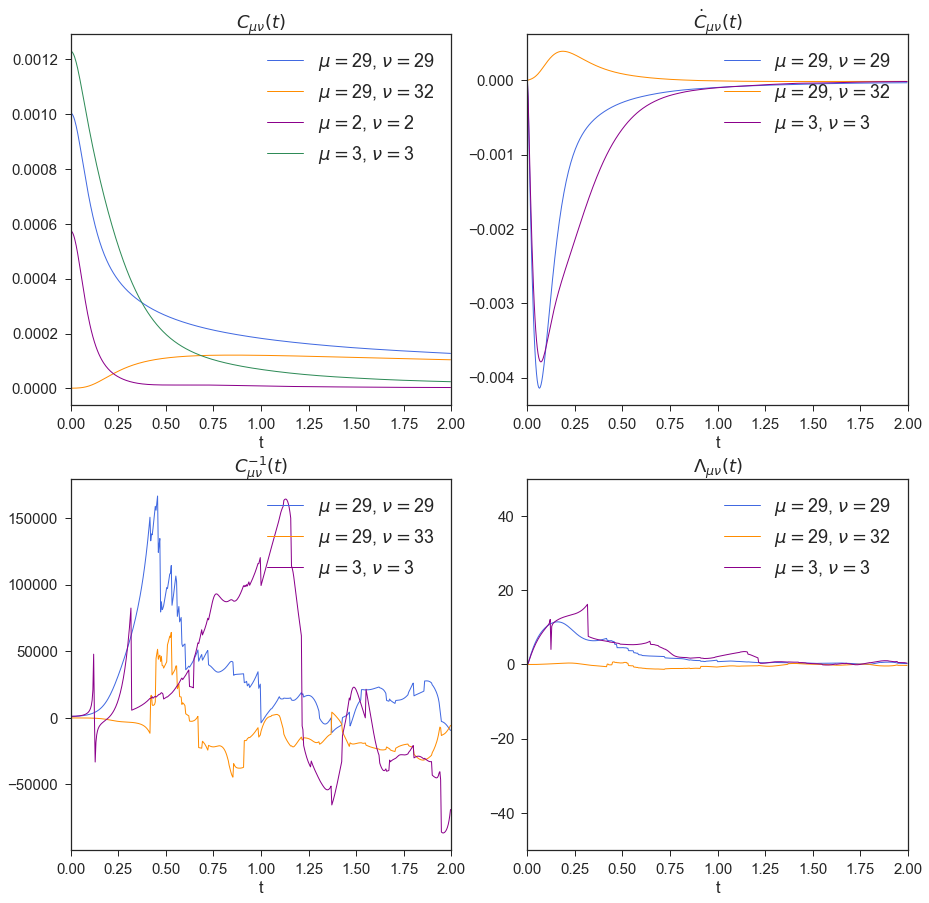

In [9]:
x  = np.arange(0, nSteps * dt, dt)

plt.figure(1, figsize=(15,15))

plt.subplot(221)
plt.plot(x, Ct[29, 29, :], label = r'$\mu=$'+str(29)+r', $\nu=$'+str(29))
plt.plot(x, Ct[29, 32, :], label = r'$\mu=$'+str(29)+r', $\nu=$'+str(32))
plt.plot(x, Ct[2, 2, :], label = r'$\mu=$'+str(2)+r', $\nu=$'+str(2))
plt.plot(x, Ct[3, 3, :], label = r'$\mu=$'+str(3)+r', $\nu=$'+str(3))
#plt.ylim(-1e-10,1e-10)
plt.xlim(0,2)
plt.title(r'$C_{\mu \nu}(t)$',fontsize=18)
plt.xlabel('t')
plt.legend(loc='upper right',fontsize=18)


plt.subplot(222)
plt.plot(x, CtDev[29, 29, :], label = r'$\mu=$'+str(29)+r', $\nu=$'+str(29))
plt.plot(x, CtDev[29, 32, :], label = r'$\mu=$'+str(29)+r', $\nu=$'+str(32))
plt.plot(x, CtDev[3, 3, :], label = r'$\mu=$'+str(3)+r', $\nu=$'+str(3))
plt.xlim(0,2)
plt.title(r'$\dot{C}_{\mu \nu}(t)$',fontsize=18)
plt.xlabel('t')
plt.legend(loc='upper right',fontsize=18)


plt.subplot(223)
plt.plot(x, CtInv[29, 29, :], label = r'$\mu=$'+str(29)+r', $\nu=$'+str(29))
plt.plot(x, CtInv[29, 32, :], label = r'$\mu=$'+str(29)+r', $\nu=$'+str(33))
plt.plot(x, CtInv[3, 3, :], label = r'$\mu=$'+str(3)+r', $\nu=$'+str(3))
plt.xlim(0,2)
plt.title(r'$C_{\mu \nu}^{-1}(t)$',fontsize=18)
plt.xlabel('t')
plt.legend(loc='upper right',fontsize=18)


plt.subplot(224)
plt.plot(x, Lambdat[29, 29, :], label = r'$\mu=$'+str(29)+r', $\nu=$'+str(29))
plt.plot(x, Lambdat[29, 32, :], label = r'$\mu=$'+str(29)+r', $\nu=$'+str(32))
plt.plot(x, Lambdat[3, 3, :], label = r'$\mu=$'+str(3)+r', $\nu=$'+str(3))
plt.xlim(0,2)
plt.ylim(-50,50)
plt.title(r'$\Lambda_{\mu \nu}(t)$',fontsize=18)
plt.xlabel('t')
plt.legend(loc='upper right',fontsize=18)
plt.show()

We will see in the next section why $C^{-1}(t)$ blows up at t=0.12. In the reciprocal space there are two modes that cross the zero at t=0.12. We thought that this "weird" behaviour was due to numerical errors but then we realized that they contain physical information about the density (layering). 

## Delete solid nodes

In [10]:
#CtNew = np.zeros((nNodesFluid-2, nNodesFluid-2, nSteps))
CtFluid = np.zeros((nNodesFluid, nNodesFluid, nSteps))

for k in range(nSteps):
    #CtNew[:,:,k] = Ct3D[3:nNodes-4, 3:nNodes-4, k]
    CtFluid[:,:,k] = Ct3D[2:nNodes-3, 2:nNodes-3, k]
Ct = CtFluid
#Ct = CtNew

In [11]:
#nNodes     = 59
nNodes     = nNodesFluid
nCols      = np.shape(Ct)[1]                  
dim        = nVar * nNodes 
B          = (1 / dz) * ((np.eye(nNodes)) - np.eye(nNodes, nNodes, -1))
F          = B.T
FInv       = inv(F)
Laplacian  = (1 / dz**2) * (-2 * (np.eye(nNodes)) +\
             np.eye(nNodes, nNodes, -nNodes+1) + np.eye(nNodes, nNodes, nNodes-1) +\
             np.eye(nNodes, nNodes, -1) + np.eye(nNodes, nNodes, 1))
C0         = Ct[:,:,0]
R          = linalg.pinv(C0, rcond = tol)

In [12]:
CtDev    = np.zeros((nNodes, nNodes, nSteps))
CtInv    = np.zeros((nNodes, nNodes, nSteps))
Lambdat  = np.zeros((nNodes, nNodes, nSteps))

for i in range(nNodes):
    CtDev[i,:,:] = ODev.dot(Ct[i,:,:].T).T
    
for k in range(nSteps):
    CtInv[:,:,k]    = linalg.pinv(Ct[:,:,k], rcond = tol)
    Lambdat[:,:,k]  = - CtDev[:,:,k].dot(CtInv[:,:,k])

# 2. RECIPROCAL SPACE
Because of the translational invariance, in PBC we can take the Fourier Transform of the matrices in order to diagonalized them. This property is broken when the system consisting on a fluid in contact with solid slabs. Therefore, we need to obtain the basis, $E$, which diagonalized the matrices when the system is not periodic. 

The ideal basis would be the one which diagonalizes $\Lambda(t)$ at each time step, but $\Lambda(t)$ is a function of $C^{-1}(t)$ (blows up at $t=0.12$). 

The route followed is to compute the basis of eigenvectors of $C(t)$ at each time step, $E(t)$. We also compute the basis at t=0.15, $E(0.15)$ and t=0.30, $E(0.30)$, to prove that $E$ has a *plateau* (we will show that $\tilde{\Lambda}(t)$ is very similar computed in the three basis). 

## 2.1. Compute $\tilde{C}(t)$, $\tilde{\dot{C}}(t)$, $\tilde{C}^{-1}(t)$ and $\tilde{\Lambda}(t)$ with $E(t)$, $E(0.15)$, $E(0.30)$ 

In [13]:
#Compute and sort eigenvalues and eigenvectors of C at t=0.15 and t=0.30 
w015, v015 = LA.eig(Ct[:,:,step(0.15)])
idx        = w015.argsort()[::-1]   
w015       = w015[idx]
v015       = v015[:,idx]
w030, v030 = LA.eig(Ct[:,:,step(0.30)])
idx        = w030.argsort()[::-1]   
w030       = w030[idx] 
v030       = v030[:,idx]

CtRec         = np.zeros((nNodes, nNodes, nSteps))
CtDevRec      = np.zeros((nNodes, nNodes, nSteps))
CtInvRec      = np.zeros((nNodes, nNodes, nSteps))
LambdatRec    = np.zeros((nNodes, nNodes, nSteps))
LambdatRec015 = np.zeros((nNodes, nNodes, nSteps))
LambdatRec030 = np.zeros((nNodes, nNodes, nSteps))
vt            = np.zeros((nNodes, nNodes, nSteps))
wt            = np.zeros((nSteps, nNodes))
for k in range(nSteps):
    #Compute and sort eigenvalues and eigenvector of C(t) at each time step
    w, v      = LA.eig((Ct[:,:,k]))
    idx       = w.argsort()[::-1]   
    w         = w[idx]
    v         = v[:,idx]
    wt[k,:]   = w
    vt[:,:,k] = v
    #Compute C(t), CDev(t), CInv(t) and Lambda(t) in the reciprocal space of C(t)
    CtRec[:,:,k]      = inv(v).dot(Ct[:,:,k]).dot(v)
    CtDevRec[:,:,k]   = inv(v).dot(CtDev[:,:,k]).dot(v)
    CtInvRec[:,:,k]   = inv(v).dot(CtInv[:,:,k]).dot(v)
    LambdatRec[:,:,k] = inv(v).dot(Lambdat[:,:,k]).dot(v)
    #Lambda(t) in the reciprocal space of C(0.15) and C(0.30)
    LambdatRec015[:,:,k] = inv(v015).dot(Lambdat[:,:,k]).dot(v015)
    LambdatRec030[:,:,k] = inv(v030).dot(Lambdat[:,:,k]).dot(v030)

## 2.2. The *plateau* of $E(t)$
We show the matrix $\tilde{\Lambda}(t)$ calculated with three basis of eigenvectors. The plot allows us to infer that we may choose the basis of eigenvector in each time, $E(t)$, because it seems time-independent

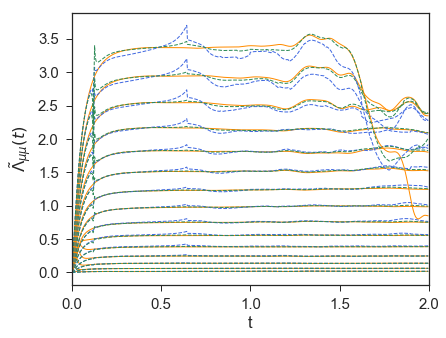

In [14]:
fig = plt.figure()
fig.set_size_inches(size1Fig)
for i in range(15):
    plt.plot(x, LambdatRec[i,i,:], color = "darkorange" )
    plt.plot(x, LambdatRec015[i,i,:], color = "royalblue", linestyle="dashed")
    plt.plot(x, LambdatRec030[i,i,:], color = "seagreen", linestyle="dashed")
plt.ylabel(r'$\tilde{\Lambda}_{\mu\mu}(t)$')
plt.xlabel('t')
plt.xlim(0,2)
#plt.savefig('../../../figures/LambdatBasis-WALLS-66nodes.pdf',dpi=1000, bbox_inches='tight')
plt.show()

#### Save files

### 2.3. Eigenvectors and eigenvalues

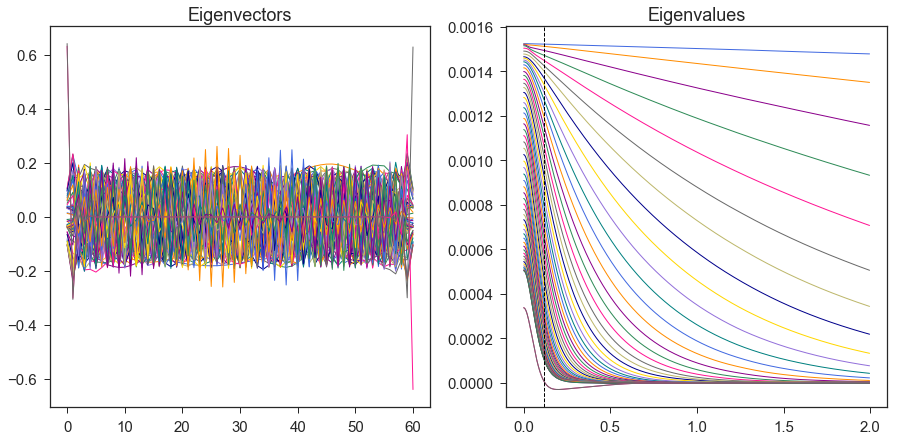

In [15]:
x = np.arange(0, nSteps*dt, dt)
plt.figure(1, figsize=(15,7))

plt.subplot(121)
for i in range(nNodes):
    plt.plot(vt[:,i,step(0.12)], label=str(i+1))
plt.title('Eigenvectors',fontsize=18)

plt.subplot(122)
for i in range(nNodes):
    plt.plot(x, wt[:,i], label=str(i+1))
plt.title('Eigenvalues',fontsize=18)
plt.axvline(x=0.12, color='k', linestyle='--', label='t=0.12')
plt.show()

Note that there are some modes which in $t=0.12$ cross $y=0$. This modes look like the density profile. Therefore, **we can not remove these modes because they contain relevant information.** In the next plots we will see in detail the corresponding eigenvectors and eigenvalues. 

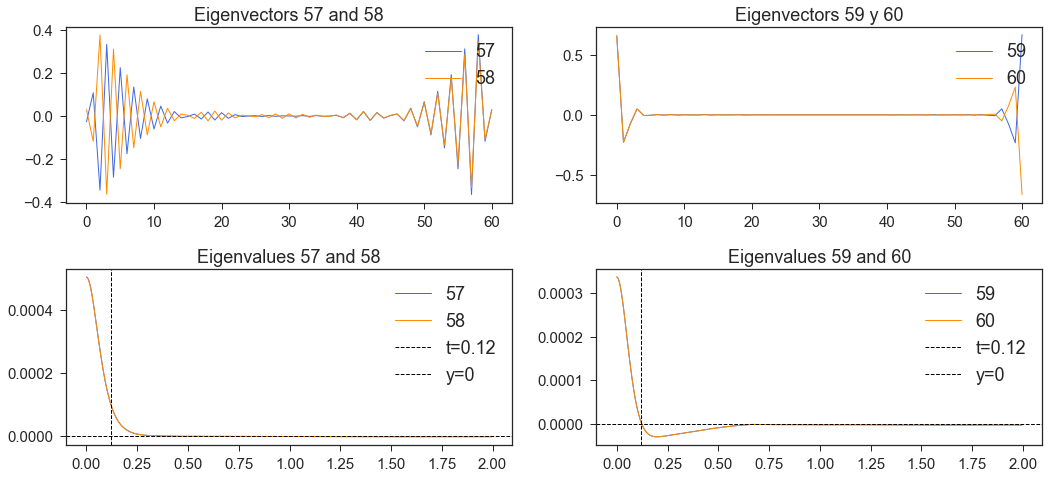

In [16]:
x = np.arange(0, nSteps*dt, dt)

plt.figure(1, figsize=(15,7))

plt.subplot(221)
for i in np.arange(57, nNodes-2, 1):
    plt.plot(vt[:,i,step(tau)], label=str(i))
plt.title('Eigenvectors 57 and 58',fontsize=18)
plt.legend(loc='upper right',fontsize=18)

plt.subplot(222)
for i in np.arange(59, nNodes, 1):
    plt.plot(vt[:,i,step(tau)], label=str(i))
plt.title('Eigenvectors 59 y 60',fontsize=18)
plt.legend(loc='upper right',fontsize=18)

plt.subplot(223)
for i in np.arange(57, nNodes-2,1):
    plt.plot(x, wt[:,i], label=str(i))
plt.title('Eigenvalues 57 and 58',fontsize=18)
plt.axvline(x=0.12, color='k', linestyle='--', label='t=0.12')
plt.axhline(y=0, color='k', linestyle='--', label='y=0')
plt.legend(loc='upper right',fontsize=18)

plt.subplot(224)
for i in np.arange(59, nNodes,1):
    plt.plot(x, wt[:,i], label=str(i))
plt.title('Eigenvalues 59 and 60',fontsize=18)
plt.axvline(x=0.12, color='k', linestyle='--', label='t=0.12')
plt.axhline(y=0, color='k', linestyle='--', label='y=0')
plt.legend(loc='upper right',fontsize=18)

plt.tight_layout() #Improve spacing between subplots
plt.show()

####  Save files

## 2.2. Chop $\tilde{C}(t)$ $\to$ $\bar{\tilde{C}}(t)$

Convert to zero all values of $\tilde{C}(t)$ smaller than a cut-off value.

In [25]:
cutOffValue = 2e-5

CtRecChop       = np.zeros((nNodes, nNodes, nSteps))
CtDevRecChop    = np.zeros((nNodes, nNodes, nSteps))
CtInvRecChop    = np.zeros((nNodes, nNodes, nSteps))
LambdatRecChop  = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    CtRecChop[:,:,k] = cutOff((CtRec[:,:,k]), cutOffValue)

for i in range(nNodes):
    CtDevRecChop[i,:,:] = ODev.dot(CtRecChop[i,:,:].T).T

for k in range(nSteps):
    CtInvRecChop[:,:,k]    = linalg.pinv(CtRecChop[:,:,k], rcond = tol)
    LambdatRecChop[:,:,k]  = - CtDevRecChop[:,:,k].dot(CtInvRecChop[:,:,k])

#Convert zeros to NaN's 
for k in range(nSteps):
    CtRecChop[:,:,k]       = zeroToNan(CtRecChop[:,:,k])
    CtDevRecChop[:,:,k]    = zeroToNan(CtDevRecChop[:,:,k])
    CtInvRecChop[:,:,k]    = zeroToNan(CtInvRecChop[:,:,k])
    LambdatRecChop[:,:,k]  = zeroToNan(LambdatRecChop[:,:,k])

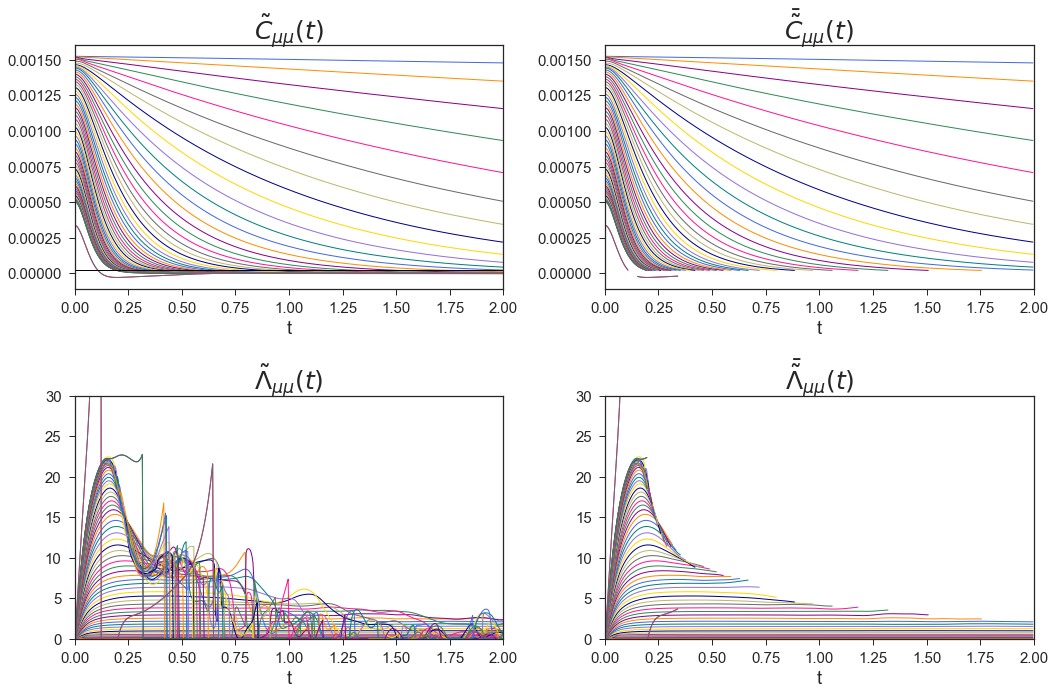

In [33]:
x = np.arange(0, nSteps * dt, dt)

plt.figure(1, figsize=(15,10))

plt.subplot(221)
for i in range(nNodes):
    plt.plot(x, CtRec[i,i,:])
    plt.plot(x, np.ones(nSteps) * cutOffValue, 'k')
plt.title(r'$\tilde{C}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
#plt.ylim(0,)

plt.subplot(222)
for i in range(nNodes):
    plt.plot(x, CtRecChop[i,i,:])
plt.title(r'$\bar{\tilde{C}}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
#plt.ylim(1e-7,2e-3)

plt.subplot(223)
for i in range(nNodes):
    plt.plot(x, LambdatRec[i,i,:])
plt.title(r'$\tilde{\Lambda}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
plt.ylim(0,30)

plt.subplot(224)
for i in range(nNodes):
    plt.plot(x, LambdatRecChop[i,i,:])
plt.title(r'$\bar{\tilde{\Lambda}}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
plt.ylim(0,30)

plt.tight_layout() #Improve spacing between subplots
plt.show()

#### Save files 

#### Plots thesis

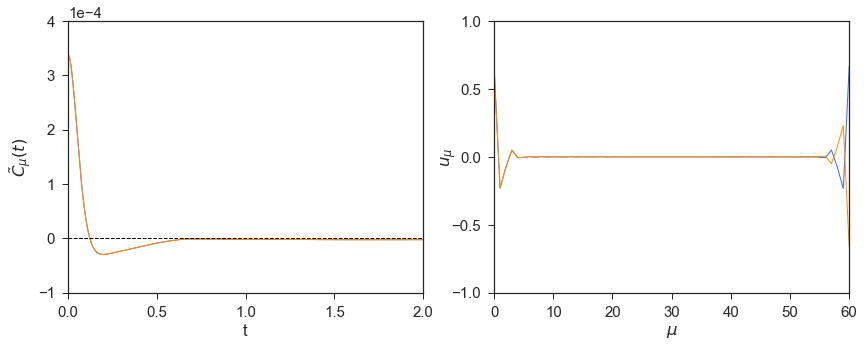

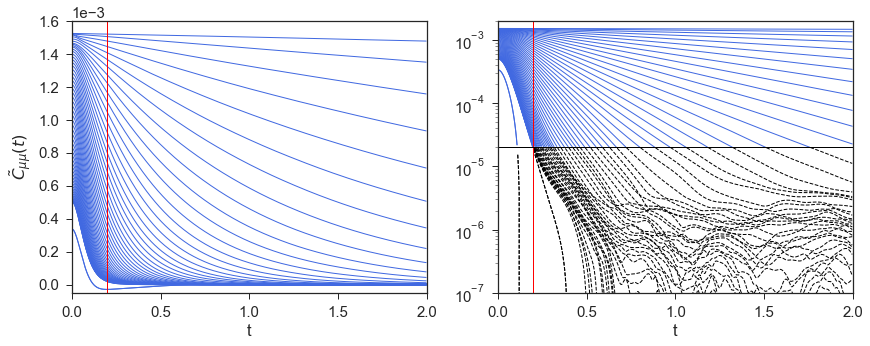

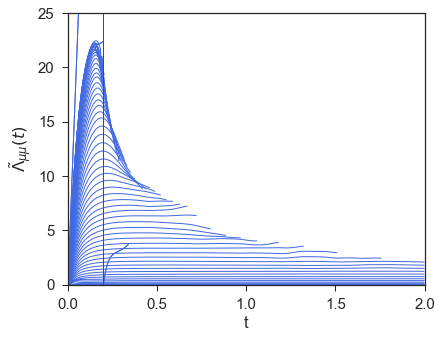

In [35]:
from matplotlib.ticker import FormatStrFormatter

x = np.arange(0, nSteps * dt, dt)
fig = plt.figure()
fig.set_size_inches(size2Fig)
plt.subplot(121)
plt.plot(x,wt[:,59])
plt.plot(x,wt[:,60])
plt.axhline(y=0, color = 'black', linestyle='dashed')
plt.xlim(0,2)
plt.ylim(-1e-4,4e-4)
plt.xlabel('t')
plt.ylabel(r'$\tilde{C}_{\mu}(t)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='plain', axis='x')
plt.subplot(122)
#changeSig = np.append(-np.ones(40), np.ones(21))
#plt.plot(range(61),vt[:,59,step(tau)]*changeSig)
plt.plot(range(61),vt[:,59,step(tau)])
plt.plot(range(61),vt[:,60,step(tau)])
plt.xlim(0,60)
plt.ylim(-1,1)
plt.xlabel(r'$\mu$')
plt.yticks(np.arange(-1, 1.5, 0.5))
plt.ylabel(r'$u_{\mu}$', labelpad=-8)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='plain', axis='x')
plt.savefig('../../../figures/EigenvaluesVectors-WALLS-66nodes.pdf',dpi=1000, bbox_inches='tight')
plt.show()


x = np.arange(0, nSteps * dt, dt)
fig = plt.figure()
fig.set_size_inches(size2Fig)
plt.subplot(121)
for i in range(nNodes):
    plt.plot(x, CtRec[i,i,:], color='royalblue')
plt.axvline(x=tau, color = 'red')
plt.xlim(0,2)
plt.ylim(-5e-5,16e-4)
plt.xlabel('t')
plt.ylabel(r'$\tilde{C}_{\mu\mu}(t)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='plain', axis='x')
plt.subplot(122)
for i in range(nNodes):
    plt.semilogy(x[CtRec[i,i,:]<cutOffValue], CtRec[i,i,:][CtRec[i,i,:]<cutOffValue], color='black', linestyle='dashed')
    plt.semilogy(x[CtRec[i,i,:]>cutOffValue], CtRec[i,i,:][CtRec[i,i,:]>cutOffValue], color='royalblue')
plt.axvline(x=tau, color = 'red')
plt.axhline(y=cutOffValue, color = 'black')
plt.xlim(0,2)
plt.ylim(1e-7,2e-3)
plt.xlabel('t')
#plt.ylabel(r'$\tilde{C}_{\mu\nu}(t)$')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='plain', axis='x')
#plt.savefig('../../../figures/CtRec-WALLS-66nodes-exp.pdf',dpi=1000, bbox_inches='tight')
plt.show()


fig = plt.figure()
fig.set_size_inches(size1Fig)
for i in range(nNodes):
    plt.plot(x, LambdatRecChop[i,i,:], color='royalblue')
plt.axvline(x=0.2, color = 'red')
#plt.axhline(y=cutOffValue, color = 'black')
plt.xlim(0,2)
plt.ylim(0,25)
plt.xlabel('t')
plt.ylabel(r'$\tilde{\Lambda}_{\mu\mu}(t)$')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='plain', axis='x')

#plt.savefig('../../../figures/LambdatRec-WALLS-66nodes.pdf',dpi=1000, bbox_inches='tight')
plt.show()

# 3. PREDICTIONS 

From the figures we may considerer that $\tilde{\Lambda}(t)$ has a plateau. We select $\tau=0.2$ as the best compromise satisfaying that $\Lambda(t)$ has attained its constant value. Therefore 

$C^{predict}(t) = exp[-\Lambda(\tau)·(t-\tau)]C(\tau)$ 

## 3.0. Load files with support t=30

In [42]:
Ctmu33nu33 = np.loadtxt('Ct-mu33nu33-66nodes-WALLS.dat') #Directly computed with LAMMPS
Ctmu2nu2   = np.loadtxt('Ct-mu2nu2-66nodes-WALLS.dat')  #This file and the next one are obtained selecting the corresponding column of Ct-66nodes-WALLS.dat
Ctmu3nu3   = np.loadtxt('Ct-mu3nu3-66nodes-WALLS.dat')

## 3.1. Compute predictions

In [43]:
nStepsPred = np.shape(Ctmu33nu33)[0]
CtPredict = np.zeros((nNodes, nNodes, nStepsPred))
for k in range(nStepsPred):
    t = k * dt
    CtPredict[:,:,k] = expm(- Lambdat[:,:,step(tau)] * (t - tau)).dot(Ct[:,:,step(tau)])

Note that the predictions are computed with the matrix of correlations obtained from the two blocks of correlations. This implies that the correlations in the bulk are influenced by the effect of the wall after a certain time. Therefore, if we want to know if the predictions fit the original correlations we must to obtain the correlations directly with LAMMPS. This is because we load the file Ct-mu33nu33-66nodes-WALLS.dat. 

Moreover, the predictions at $t=\tau$ do not need to match with $C(\tau)$. We have checked that the difference increases according to the distance from the diagonal (obviously).

## 3.2. Plot $C(t)$ and the predictions

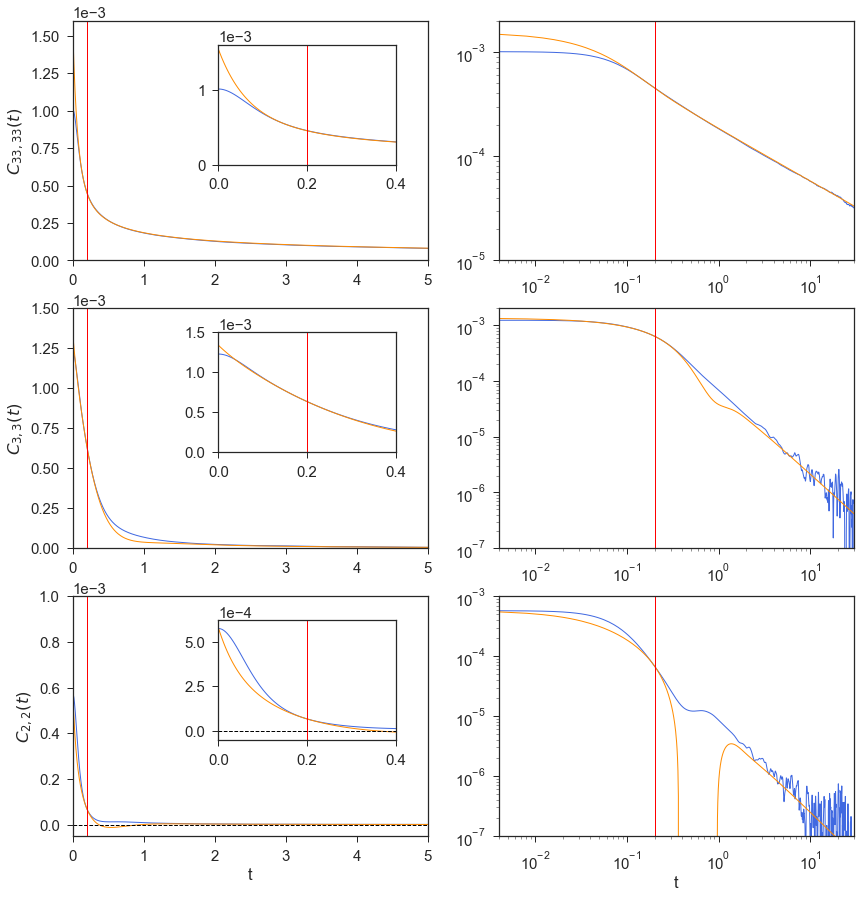

In [139]:
x = np.arange(0, nStepsPred * dt, dt)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size6Fig))

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]
ax5 = axs[2,0]
ax6 = axs[2,1]
#Autocorrelation in the middle of the channel 
ax1.plot(x, Ctmu33nu33)
ax1.plot(x, CtPredict[31,31,:])
ax1.axvline(x=tau, color = 'red')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_xlim([0, 5])
ax1.set_ylim([0, 1.6e-3])
#ax1.set_xlabel('t')
ax1.set_ylabel(r'$C_{33,33}(t)$')
    
ax2.loglog(x, Ctmu33nu33)
ax2.loglog(x, CtPredict[31,31,:])
ax2.axvline(x=tau, color = 'red')
ax2.set_xlim([0, 30])
ax2.set_ylim([1e-5, 2e-3])
#ax2.set_xlabel('t')
# inset
box            = ax1.get_position()
width          = box.width
height         = box.height
rect           = [0.41,0.4,0.4,0.4]
inax_position  = ax1.transAxes.transform(rect[0:2])
transFigure    = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
pos_x          = infig_position[0]
pos_y          = infig_position[1]
width         *= 0.5
height        *= 0.5

subax          = fig.add_axes([pos_x,pos_y,width,height])

subax.plot(x, Ctmu33nu33, color="royalblue")
subax.plot(x, CtPredict[31,31,:], color = "darkorange")
subax.axvline(x=tau, color = 'red')
subax.set(xlim=[0,0.4], ylim=[0, 1.6e-3])
subax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
subax.axvline(x=tau, color = 'red')


#Autocorrelation near the wall mu=nu=3
ax3.plot(x, Ctmu3nu3)
ax3.plot(x, CtPredict[1,1,:])
ax3.axvline(x=tau, color = 'red')
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.set_xlim([0, 5])
ax3.set_ylim([0, 1.5e-3])
#ax3.set_xlabel('t')
ax3.set_ylabel(r'$C_{3,3}(t)$')
    
ax4.loglog(x, Ctmu3nu3)
ax4.loglog(x, CtPredict[1,1,:])
ax4.axvline(x=tau, color = 'red')
ax4.set_xlim([0, 30])
ax4.set_ylim([1e-7, 2e-3])
#ax4.set_xlabel('t')
# inset
box            = ax3.get_position()
width          = box.width
height         = box.height
rect           = [0.41,0.4,0.4,0.4]
inax_position  = ax3.transAxes.transform(rect[0:2])
transFigure    = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
pos_x          = infig_position[0]
pos_y          = infig_position[1]
width         *= 0.5
height        *= 0.5

subax          = fig.add_axes([pos_x,pos_y,width,height])

subax.plot(x, Ctmu3nu3, color="royalblue")
subax.plot(x, CtPredict[1,1,:], color = "darkorange")
subax.axvline(x=tau, color = 'red')
subax.set(xlim=[0,0.4], ylim=[0, 1.5e-3])
subax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
subax.axvline(x=tau, color = 'red')


#Autocorrelation near the wall mu=nu=2
ax5.plot(x, Ctmu2nu2)
ax5.plot(x, CtPredict[0,0,:])
ax5.axhline(y=0, color = 'black', linestyle="dashed")
ax5.axvline(x=tau, color = 'red')
ax5.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax5.set_xlim([0, 5])
ax5.set_ylim([-0.5e-4, 1e-3])
ax5.set_xlabel('t')
ax5.set_ylabel(r'$C_{2,2}(t)$')
    
ax6.loglog(x, Ctmu2nu2)
ax6.loglog(x, CtPredict[0,0,:])
ax6.axvline(x=tau, color = 'red')
ax6.set_xlim([0, 30])
ax6.set_ylim([1e-7, 1e-3])
ax6.set_xlabel('t')
# inset
box            = ax5.get_position()
width          = box.width
height         = box.height
rect           = [0.41,0.4,0.4,0.4]
inax_position  = ax5.transAxes.transform(rect[0:2])
transFigure    = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
pos_x          = infig_position[0]
pos_y          = infig_position[1]
width         *= 0.5
height        *= 0.5

subax          = fig.add_axes([pos_x,pos_y,width,height])

subax.plot(x, Ctmu2nu2, color="royalblue")
subax.plot(x, CtPredict[0,0,:], color = "darkorange")
subax.axhline(y=0, color = 'black', linestyle="dashed")
subax.axvline(x=tau, color = 'red')
subax.set(xlim=[0,0.4], ylim=[-0.5e-4, 6.2e-4])
subax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
subax.axvline(x=tau, color = 'red')


#plt.savefig('../../../figures/Predictions-WALLS-66nodes.pdf',dpi=1000, bbox_inches='tight')
plt.show()

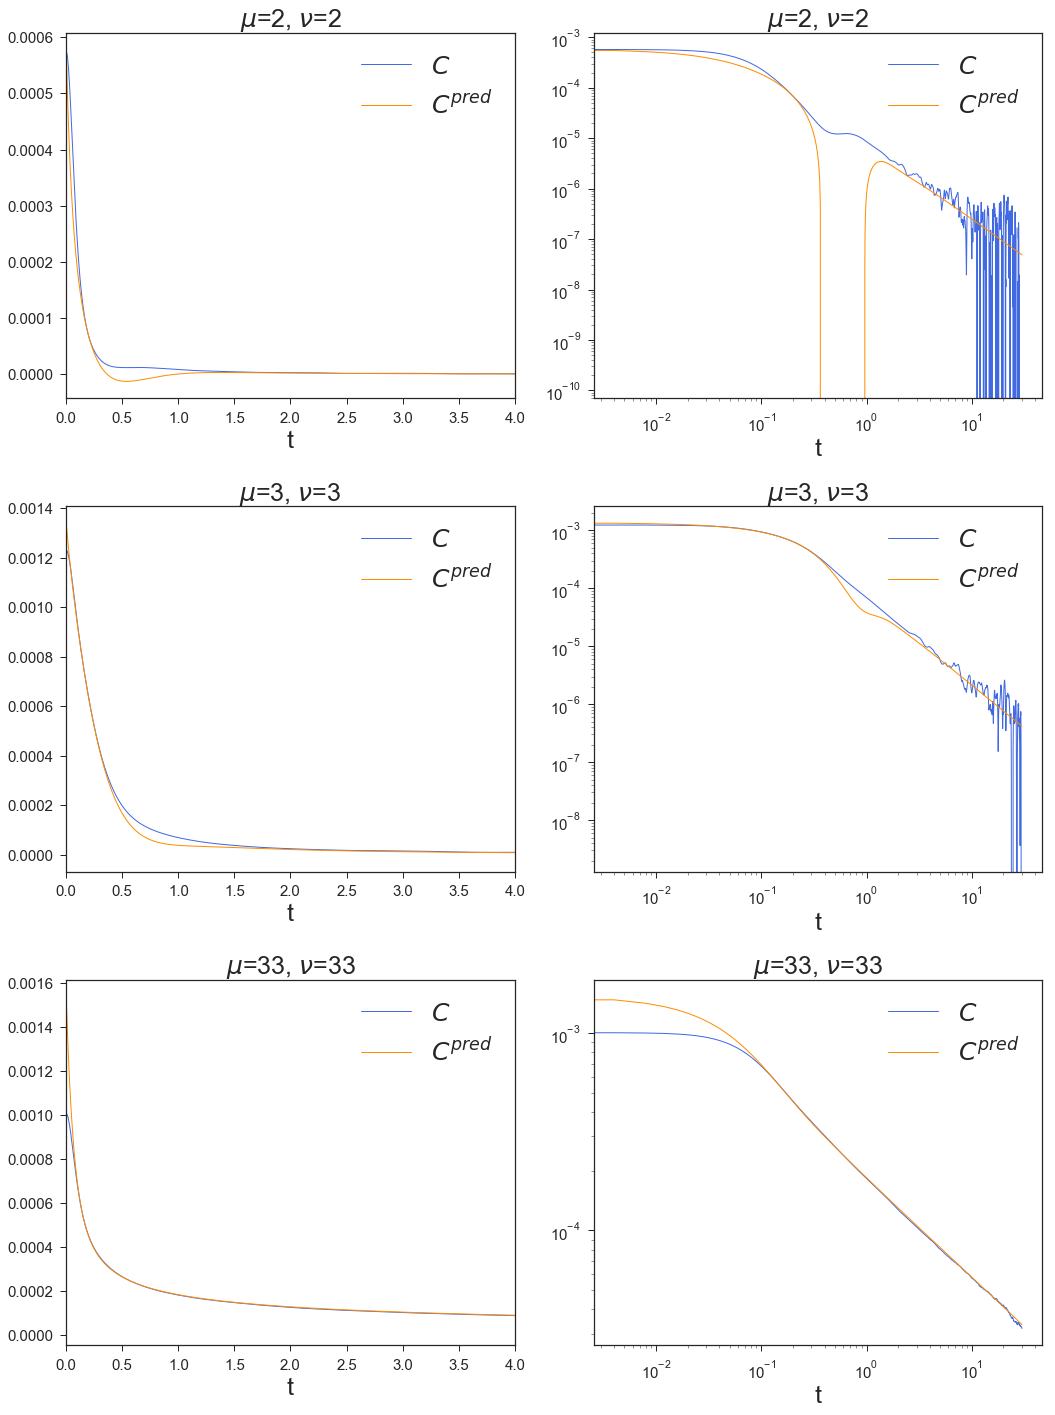

In [44]:
x = np.arange(0, nStepsPred * dt, dt)
plt.figure(1, figsize=(15,20))

plt.subplot(321)
plt.plot(x, Ctmu2nu2, label='$C$')
plt.plot(x, CtPredict[0,0,:], label=r'$C^{pred}$')
plt.xlim(0,4)
plt.title(r'$\mu$=2, $\nu$=2',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(322)
plt.loglog(x, Ctmu2nu2, label='$C$')
plt.loglog(x, CtPredict[0,0,:], label=r'$C^{pred}$')
plt.title(r'$\mu$=2, $\nu$=2',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(323)
plt.plot(x, Ctmu3nu3, label='$C$')
plt.plot(x, CtPredict[1,1,:], label=r'$C^{pred}$')
plt.xlim(0,4)
plt.title(r'$\mu$=3, $\nu$=3',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(324)
plt.loglog(x, Ctmu3nu3, label='$C$')
plt.loglog(x, CtPredict[1,1,:], label=r'$C^{pred}$')
plt.title(r'$\mu$=3, $\nu$=3',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(325)
plt.plot(x, Ctmu33nu33, label='$C$')
plt.plot(x, CtPredict[31,31,:], label=r'$C^{pred}$')
plt.xlim(0,4)
plt.title(r'$\mu$=33, $\nu$=33',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(326)
plt.loglog(x, Ctmu33nu33, label='$C$')
plt.loglog(x, CtPredict[31,31,:], label=r'$C^{pred}$')
plt.title(r'$\mu$=33, $\nu$=33',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.tight_layout() #Improve spacing between subplots
plt.show()

#### Save files

# NEW ---------------------------------------------

# 4. Averages gx(t)

In [16]:
gxtv05 = np.loadtxt('gx-avg-v05-66nodes.dat')
nStepsPF = np.shape(gxtv05)[0]
gxt = np.zeros((nStepsPF, nNodes))
for k in range(nStepsPF):
    gxt[k,:] = 0.5 * (gxtv05[k,2:-3] + np.flip(gxtv05[k,2:-3], axis=0))    

In [17]:
gxtPredict   = np.zeros((nStepsPF, nNodes))
for k in range(nStepsPF):
    t = k * dt
    expLambda = expm(- Lambdat[:,:,step(tau)] * (t-tau))
    expLambda[0,0] = 0   #hacemos 0 la componente 0,0 de la exponencial de lambda
    gxtPredict[k,:]   = expLambda.dot(gxt[step(tau),:])

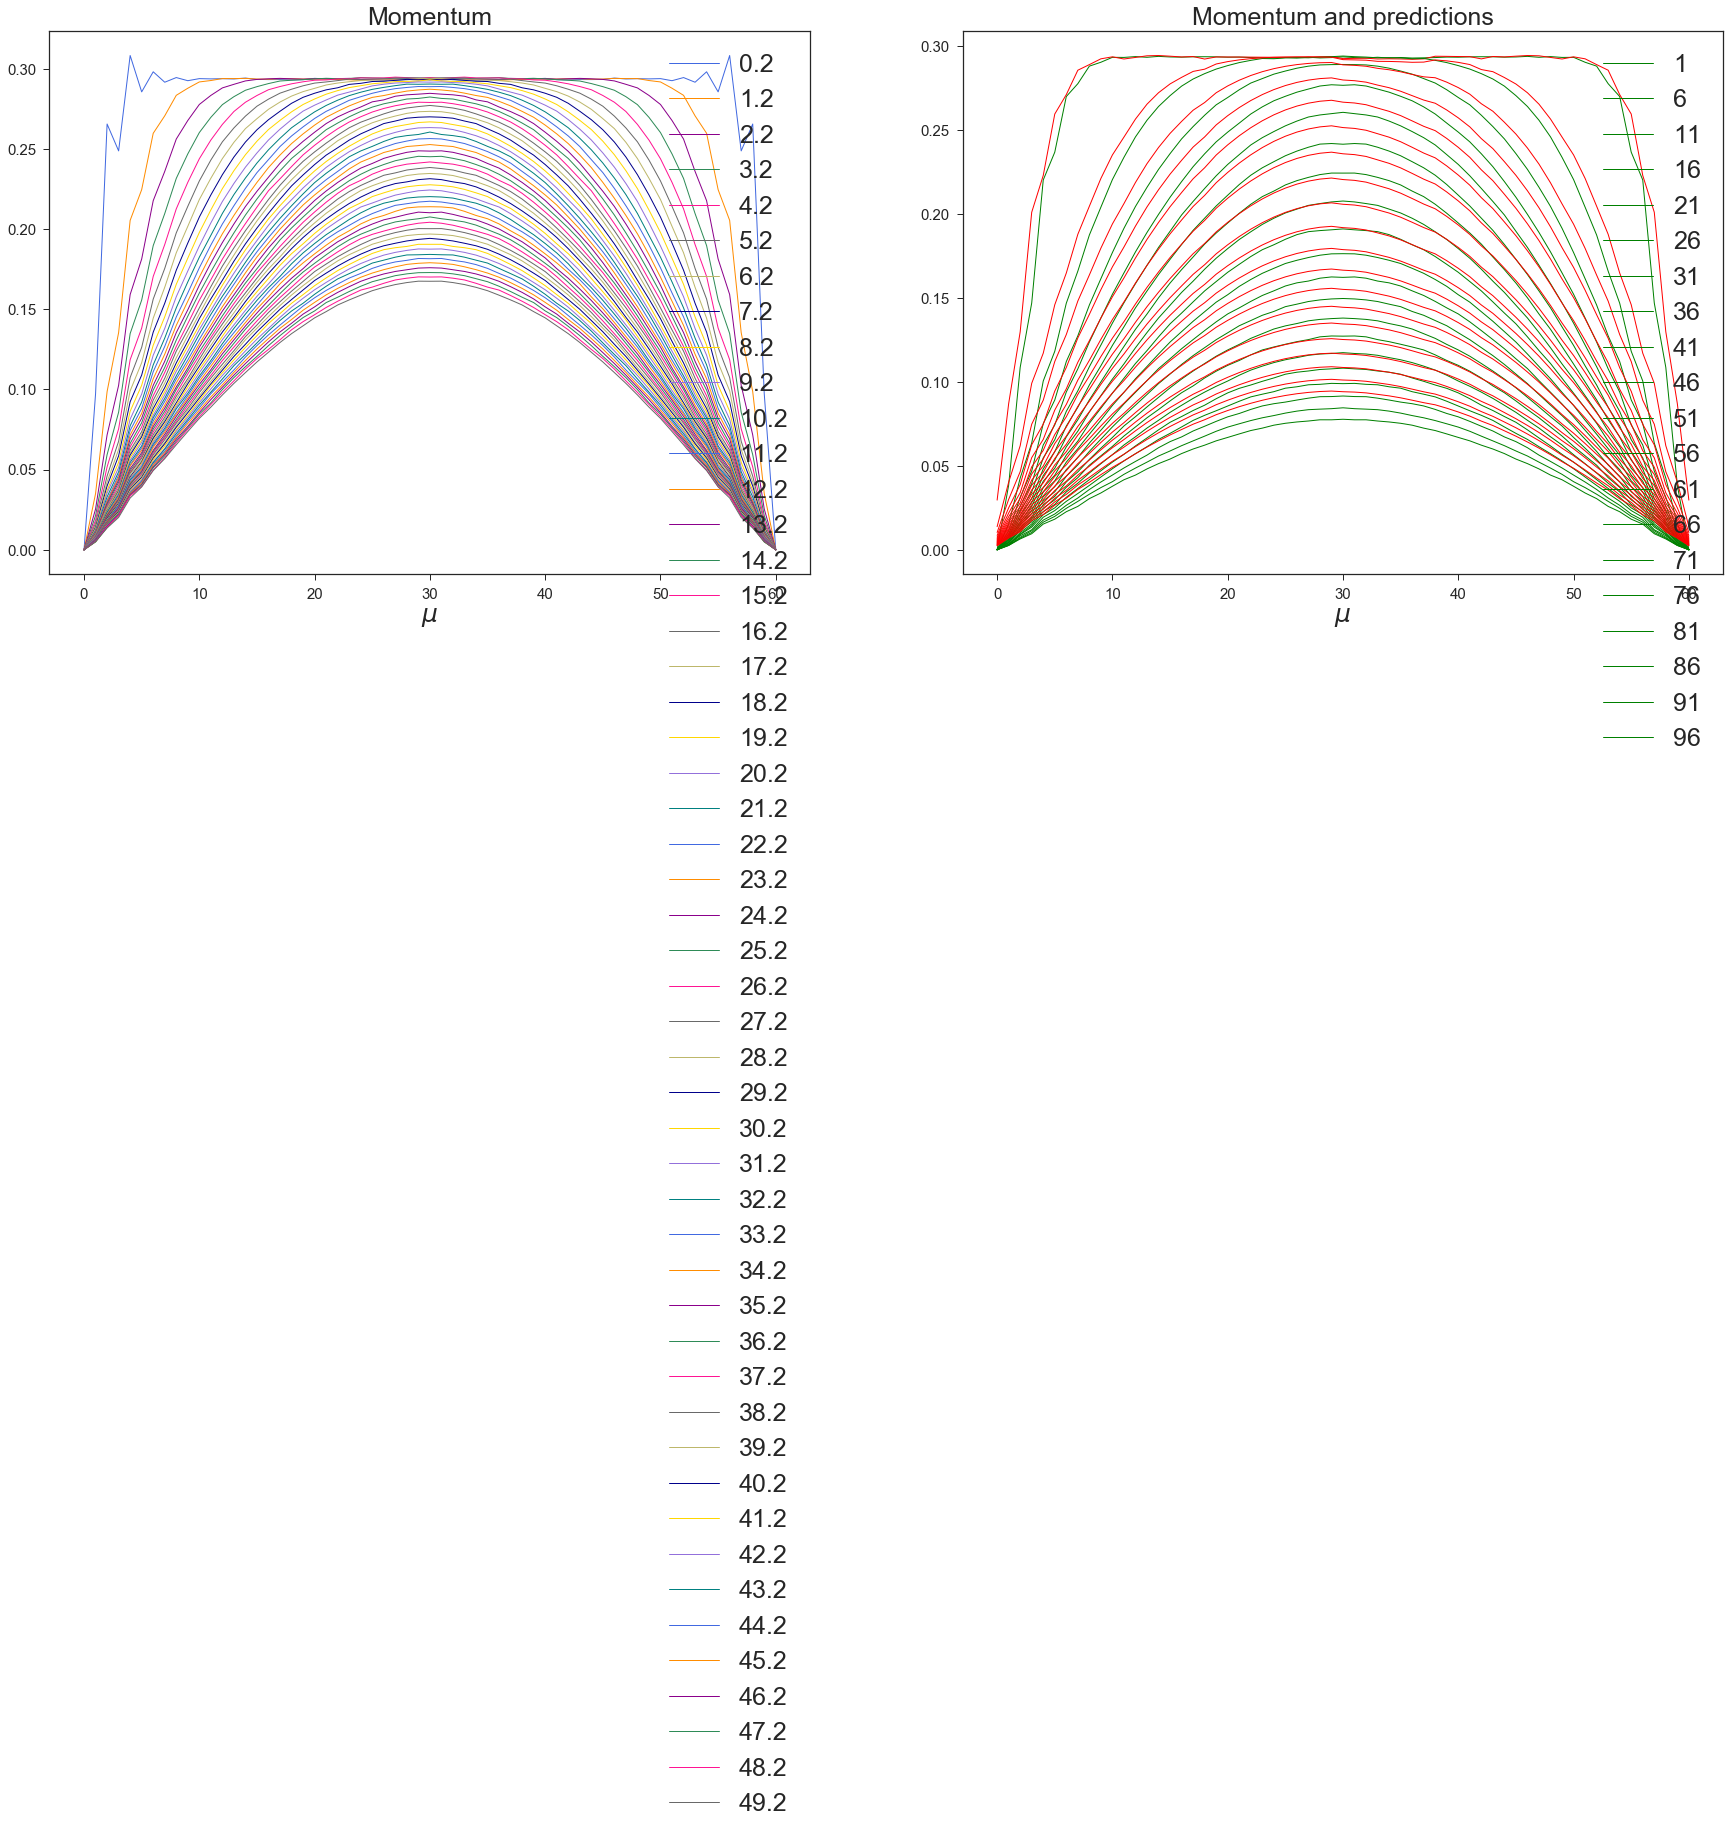

In [18]:
plt.figure(1, figsize=(30,10))

plt.subplot(121)
for t in np.arange(0.2,50,1):
    plt.plot(gxt[step(t),:], label=str(t))
    plt.xlabel(r'$\mu$',fontsize=25)
    plt.legend(loc='upper right',fontsize=25)
    plt.title('Momentum',fontsize=25)

plt.subplot(122)
#for k in np.arange(step(tau),step(20), step(2)):
for t in np.arange(1, 100, 5):
    plt.plot(gxt[step(t),:],'g', label=str(t))
    plt.plot(gxtPredict[step(t),:], 'r')
    plt.legend(loc='upper right',fontsize=25)
    plt.xlabel(r'$\mu$',fontsize=25)
    plt.title('Momentum and predictions',fontsize=25)
plt.show()

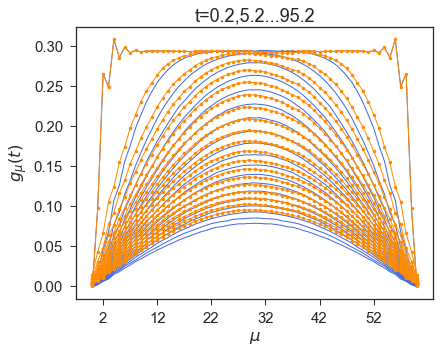

In [19]:
fig = plt.figure()
fig.set_size_inches(6.4,5)
for t in np.arange(0.2, 100, 5):
    plt.plot(gxt[step(t),:], color='royalblue')
    plt.plot(gxtPredict[step(t),:], '.',color='darkorange')
    plt.plot(gxtPredict[step(t),:],color='darkorange')
plt.xticks(np.arange(2, 62, 10))
plt.title('t=0.2,5.2...95.2')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$g_{\mu}(t)$')
#plt.savefig('../../filesGNUPLOT/pf-66nodes.pdf')
plt.show()